<a href="https://colab.research.google.com/github/abhishekshwarma/abhishekshwarma/blob/main/allostery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install jax_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 28.6 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=bf042328be38fde7be82be53f58f0fabacc09a61722cf024d7fb4fae96cdff7a
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [1]:
import jax.numpy as np
from jax import random
from jax import ops
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize, simulate, quantity
from jax import random, grad, vmap
from jax import jit
import networkx as nx
import numpy as onp
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [3]:
def plot_configuration(node_positions, bond_array, box_size):
    # Create an empty plot
    fig, ax = plt.subplots()

    # Plot the node positions
    for i, position in enumerate(node_positions):
        ax.scatter(position[0], position[1], s=50, c='red', label='Node')

    # Plot the bonds
    for bond in bond_array:
        start_node = node_positions[bond[0]]
        end_node = node_positions[bond[1]]
        ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'b-', linewidth=2, label='Bond')


    # Customize the plot
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Show the plot
    plt.show()

In [4]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with lengths less than r_c.
    EL = L[R < r_c]

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)

    return N, G, X, E, L

def getSurfaceNodes(G, NS):
    # Retrieve the list of nodes in the graph G
    nodes = np.array(list(G.nodes))
    # Calculate the x and y coordinates of the nodes based on the grid size NS
    x_values = nodes % NS
    y_values = nodes // NS
    # Find the nodes located on the top surface (y = NS - 1)
    top_nodes = nodes[y_values == NS - 1]
    # Find the nodes located on the bottom surface (y = 0)
    bottom_nodes = nodes[y_values == 0]
    # Find the nodes located on the left surface (x = 0)
    left_nodes = nodes[x_values == 0]
    # Find the nodes located on the right surface (x = NS - 1)
    right_nodes = nodes[x_values == NS - 1]
    # Return a dictionary with surface names as keys and node arrays as values
    return {
        'top': top_nodes,
        'bottom': bottom_nodes,
        'left': left_nodes,
        'right': right_nodes
    }

### Functions

In [10]:
def make_box(R, padding):
    """
    Defines a box length
    """
    box_length = (np.max((np.max(R[:,0],R[:,1])) - np.min(((np.min(R[:,0],R[:,1])))))) + padding
    return box_length

def createSpringConstants(R,E,k_1):
    #k_1 is the spring constant for a spring of unit length
    displacements = R[E[:, 0],:]-R[E[:, 1], :]
    distance = np.linalg.norm(displacements, axis=1)
    return (k_1/distance).reshape(-1,1),distance

def compute_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


def displace_sources(R, source_idx, delta):
    """
    Adjust the R of two source points along their connecting vector.
    """
    source_vector = R[source_idx[1], :] - R[source_idx[0], :]
    unit_vector = source_vector / np.linalg.norm(source_vector)

    # Displace both source points along the unit vector, half the delta in opposite directions.
    displacement = 0.5 * delta * unit_vector
    R = R.at[source_idx[0], :].set(R[source_idx[0]] - displacement)
    R = R.at[source_idx[1], :].set(R[source_idx[1]] + displacement)
    return R


# def constrained_force_fn(R):
#     """
#     Calculates forces with frozen sources.
#     """
#     force_fn = quantity.force(energy_fn)  #calculates gradients
#     total_force = force_fn(R)
#     total_force = total_force.at[source_idx, :].set(0.0)

#     return total_force

def minimize_config(R, k_bond, label, shift, etol, max_steps):

    energy_fn = energy.simple_spring_bond(displacement, E, length=bond_lengths, epsilon=k_bond[:,0])

    force_fn = quantity.force(energy_fn)  #calculates gradients

    def constrained_force_fn(R):
        """
        Calculates forces with frozen sources.
        """
        force_fn = quantity.force(energy_fn)  #calculates gradients
        total_force = force_fn(R)
        total_force = total_force.at[source_idx, :].set(0.0)

        return total_force

    if label == 'pinched': chosen_force_fn = constrained_force_fn

    else: chosen_force_fn = force_fn

    print_every = 10
    fire_init, fire_apply = minimize.fire_descent(chosen_force_fn, shift)
    fire_apply = jit(fire_apply)
    fire_state = fire_init(R)


    # Running the minimization
    energies = []
    trajectory = []
    for step in range(max_steps):
      fire_state = fire_apply(fire_state)

      energies += [energy_fn(fire_state.position)]
      trajectory += [fire_state.position]
      if step % print_every == 0:
            R = fire_state.position
            #print(label,step, energy_fn(R), np.max(chosen_force_fn(R))) #{:.2f}\t{:.2f}\t{:.2f}'.format

      if energy_fn(R) <= etol:
        break

    R_final = fire_state.position
    traj = np.stack(trajectory)
    traj_energy = np.stack(energies)
    return R_final, traj, traj_energy, step

def obtain_strain(initial_R, final_R, source_idx, target_idx):
    """
    Calculate the strains for the source and target regions based on initial and final R.
    """
    # Extract R for source and target regions.
    initial_source_R = initial_R[source_idx, :]
    final_source_R = final_R[source_idx, :]
    initial_target_R = initial_R[target_idx, :]
    final_target_R = final_R[target_idx, :]

    # Calculate distances for initial and final configurations.
    d_source_initial = compute_distance(initial_source_R[0], initial_source_R[1])
    d_source_final = compute_distance(final_source_R[0], final_source_R[1])
    d_target_initial = compute_distance(initial_target_R[0], initial_target_R[1])
    d_target_final = compute_distance(final_target_R[0], final_target_R[1])

    # Calculate the strains.
    source_strain = (d_source_final - d_source_initial) / d_source_initial
    target_strain = (d_target_final - d_target_initial) / d_target_initial

    return source_strain, target_strain


def fitness(source_strain, target_strain, goal_strain):
    """
    Calculate the fitness based on the strains.
    """
    eta = target_strain / source_strain
    return np.abs(1 - eta / goal_strain)


def update_kbonds(gradients, k_bond, learning_rate = 0.2):
    """
    Updates spring constants based on gradients.
    """
    gradients_perpendicular = gradients - np.mean(gradients)
    gradients_normalized = gradients_perpendicular / np.max(gradients_perpendicular)
    k_bond_new = k_bond * (1 - learning_rate * gradients_normalized)

    return k_bond_new

### Consolidated Function

In [11]:
def simulate_allostery(R, k_bond, source_idx, target_idx, shift, eta_star, ds):
    R_init, traj1, _, step = minimize_config(R, k_bond, 'initial', shift, etol = 1e-6, max_steps = 200)
    R_new = displace_sources(R_init, source_idx, ds)
    R_final, traj2, _, step = minimize_config(R_new, k_bond, 'pinched', shift, etol = 1e-6, max_steps = 200)
    source_strain, target_strain = obtain_strain(R_init, R_final, source_idx, target_idx)
    fit = fitness(source_strain, target_strain, eta_star)

    return fit #, traj1, traj2, step



In [12]:
#create graph
N,G,X,E,bond_lengths =createDelaunayGraph(10, 25, 2.0, 0.4)
R = np.array(X)
#k_bond, _ = createSpringConstants(R,E,1.0)
# Constants representing source and target points.
source_idx = np.array([6, 27])
target_idx = np.array([91, 83])
displacement, shift = space.free() #displacement = points in space, shift = small shifts of each particle
grad_f = grad(simulate_allostery, argnums=1)

In [19]:

opt_steps = 10
k_temp = k_bond
for i in range(opt_steps):
    net_fitness = simulate_allostery(R, k_temp, source_idx, target_idx, shift, eta_star=1, ds=0.1)
    gradients = grad_f(R, k_temp, source_idx, target_idx, shift, eta_star=1, ds=0.1)
    k_temp = k_temp.at[np.argmax(gradients)].set(0.5*k_temp[np.argmax(gradients)])
    print(i, np.max(gradients), net_fitness)


0 0.0005625180906845509 1.0006015757657227
1 0.0009951972380311484 1.0002844868014484
2 0.0014798663650709832 1.000010720841281
3 0.001140230602017686 0.9999778515381696
4 0.004824418362460471 0.9998056961488784
5 0.0043290291979544305 0.9996704010837666
6 0.002824056539981582 0.9996194546706338
7 0.0017975275022377034 0.9996032159171017
8 0.0012899628541967983 0.9995979107516714
9 0.004187818731099918 0.9989719818398559


In [23]:
def simulate_allostery_node(R, source_idx, target_idx, shift, eta_star, ds):
    k_bonds, _ = createSpringConstants(R,E,1.0)
    R_init, traj1, _, step = minimize_config(R, k_bonds, 'initial', shift, etol = 1e-6, max_steps = 200)
    R_new = displace_sources(R_init, source_idx, ds)
    R_final, traj2, _, step = minimize_config(R_new, k_bonds, 'pinched', shift, etol = 1e-6, max_steps = 200)
    source_strain, target_strain = obtain_strain(R_init, R_final, source_idx, target_idx)
    fit = fitness(source_strain, target_strain, eta_star)

    return fit #, traj1, traj2, step

In [24]:

gradR_f = grad(simulate_allostery_node, argnums=0)

In [26]:
gradients = gradR_f(R, source_idx, target_idx, shift, eta_star=1, ds=0.1)

In [27]:
gradients

Array([[-8.77148110e-05,  1.62125440e-04],
       [ 1.35033025e-04,  3.12739949e-04],
       [-3.37343263e-04,  1.58026128e-04],
       [ 7.79170562e-05, -1.55427675e-04],
       [ 1.38871751e-04,  1.63934028e-05],
       [ 2.07480676e-04, -1.65152397e-04],
       [ 2.62141865e-02, -2.22393042e-02],
       [ 1.31611384e-04,  1.58861719e-04],
       [-1.55984855e-05,  1.46000479e-04],
       [ 3.25337345e-06,  3.65405203e-05],
       [ 9.06277881e-05,  4.42209296e-04],
       [-2.97223160e-04,  1.54184384e-04],
       [ 1.00491334e-04,  1.22752698e-04],
       [-8.14530791e-06,  3.67841380e-04],
       [ 1.18064968e-04,  5.65201032e-05],
       [ 9.35255885e-05, -8.92065193e-05],
       [-5.94813348e-05, -9.02519104e-04],
       [-2.22737254e-04,  3.41224928e-04],
       [ 1.26239934e-04,  1.49424527e-04],
       [ 4.88476802e-04, -6.87344714e-05],
       [ 6.46016115e-05,  1.63073140e-04],
       [-8.24839011e-05, -6.72652253e-05],
       [ 2.18514562e-04,  5.40891576e-05],
       [-2.

In [33]:
np.linalg.norm(gradients,axis=1)

Array([1.84332706e-04, 3.40646728e-04, 3.72522126e-04, 1.73864400e-04,
       1.39836000e-04, 2.65185869e-04, 3.43768850e-02, 2.06297364e-04,
       1.46831375e-04, 3.66850660e-05, 4.51400551e-04, 3.34834931e-04,
       1.58640263e-04, 3.67931552e-04, 1.30896367e-04, 1.29247200e-04,
       9.04477066e-04, 4.07487835e-04, 1.95612397e-04, 4.93288975e-04,
       1.75403014e-04, 1.06434038e-04, 2.25109420e-04, 3.05993333e-04,
       1.06740066e-04, 1.73246209e-04, 3.89953355e-04, 3.79043358e-02,
       2.35339872e-04, 1.82185458e-04, 3.61689106e-04, 2.36463533e-04,
       3.25134837e-04, 1.48515302e-04, 2.16073141e-04, 2.39810657e-04,
       2.15142931e-04, 4.80435114e-05, 1.94403092e-04, 1.33635956e-04,
       1.96278907e-04, 3.56571531e-04, 2.71217612e-04, 3.28574662e-04,
       6.03938575e-05, 7.79250328e-05, 2.64197506e-04, 2.40409805e-04,
       1.41683249e-04, 3.68841474e-04, 5.03184630e-04, 5.62428107e-04,
       2.55335141e-04, 2.42596554e-04, 1.53420053e-04, 5.10746322e-04,
      

In [45]:
def update_R(gradients, R_current, max_disp):
    """
    Updates positions based on gradients.
    """
    gradients_normalized = gradients / np.max(np.linalg.norm(gradients,axis=1))
    R_updated = R_current - max_disp*gradients_normalized

    return R_updated

In [47]:
opt_steps = 10
R_temp=R
for i in range(opt_steps):
    net_fitness = simulate_allostery_node(R_temp, source_idx, target_idx, shift, eta_star=1, ds=0.1)
    gradients = gradR_f(R_temp, source_idx, target_idx, shift, eta_star=1, ds=0.1)
    R_temp=update_R(gradients,R_temp, 0.2)
    print(i, np.max(gradients), net_fitness)

0 14.217419341027433 1.0006015757657227
1 0.032556701992349994 1.001966969023159
2 0.025915351923481995 0.9991007703185075
3 0.006303503615738063 1.0008368719032692
4 0.006530511447910958 0.9990362583306939
5 0.021002282275531553 1.001818918716717
6 3.2742517499224943 0.9997802474062522
7 0.014279276643102941 1.0002585270458493
8 0.11039208865868815 1.0005648503594755
9 0.0010776110776381568 1.0007946582863678


In [42]:
gradients = gradR_f(R, source_idx, target_idx, shift, eta_star=1, ds=0.1)
gradients

Array([[-8.77148110e-05,  1.62125440e-04],
       [ 1.35033025e-04,  3.12739949e-04],
       [-3.37343263e-04,  1.58026128e-04],
       [ 7.79170562e-05, -1.55427675e-04],
       [ 1.38871751e-04,  1.63934028e-05],
       [ 2.07480676e-04, -1.65152397e-04],
       [ 2.62141865e-02, -2.22393042e-02],
       [ 1.31611384e-04,  1.58861719e-04],
       [-1.55984855e-05,  1.46000479e-04],
       [ 3.25337345e-06,  3.65405203e-05],
       [ 9.06277881e-05,  4.42209296e-04],
       [-2.97223160e-04,  1.54184384e-04],
       [ 1.00491334e-04,  1.22752698e-04],
       [-8.14530791e-06,  3.67841380e-04],
       [ 1.18064968e-04,  5.65201032e-05],
       [ 9.35255885e-05, -8.92065193e-05],
       [-5.94813348e-05, -9.02519104e-04],
       [-2.22737254e-04,  3.41224928e-04],
       [ 1.26239934e-04,  1.49424527e-04],
       [ 4.88476802e-04, -6.87344714e-05],
       [ 6.46016115e-05,  1.63073140e-04],
       [-8.24839011e-05, -6.72652253e-05],
       [ 2.18514562e-04,  5.40891576e-05],
       [-2.

In [43]:
update_R(R,0.1)

Array([[0.10505638, 0.10671055],
       [0.1156377 , 0.10898835],
       [0.12206101, 0.1093822 ],
       [0.12767054, 0.10754191],
       [0.13559374, 0.10794722],
       [0.14366132, 0.10940711],
       [0.15058802, 0.10669235],
       [0.15940947, 0.10706431],
       [0.16565   , 0.10603871],
       [0.17260154, 0.10525033],
       [0.10729059, 0.11427192],
       [0.11503884, 0.11150753],
       [0.12146827, 0.11402739],
       [0.13140888, 0.11310288],
       [0.13637084, 0.11472916],
       [0.14435475, 0.11206649],
       [0.14930891, 0.11461921],
       [0.15867493, 0.11421838],
       [0.16430993, 0.11295718],
       [0.16994684, 0.11250657],
       [0.10961342, 0.12071765],
       [0.11546289, 0.12141075],
       [0.11891761, 0.11934798],
       [0.12990909, 0.121479  ],
       [0.13828048, 0.12073572],
       [0.14521262, 0.12001871],
       [0.15271596, 0.12252106],
       [0.15643345, 0.12149718],
       [0.16375879, 0.12096327],
       [0.17057491, 0.12203733],
       [0.

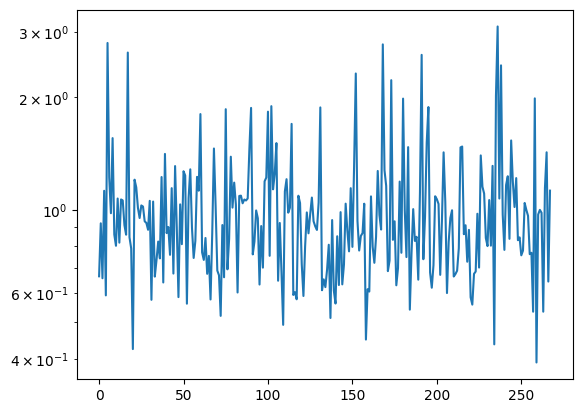

In [ ]:
plt.plot(k_temp)
plt.yscale('log')

### Visuals

In [ ]:
R_new = displace_sources(R, source_idx, 0.5)

In [ ]:
bond_array = np.array(E)

In [ ]:
plot_configuration(R, bond_array, box_length)

NameError: name 'box_length' is not defined

In [1]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj_shifted)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)

# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0]], "y": [frame[:, 1]]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()


NameError: ignored

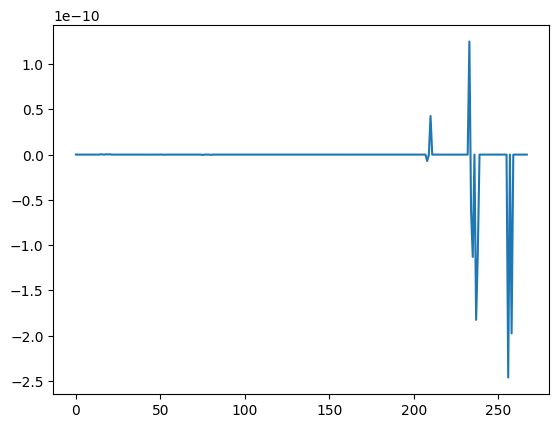

In [ ]:
plt.plot(gradients)

In [ ]:
k_bond.shape

(268, 1)

# Charges

In [ ]:
soft_sphere_fn = energy.soft_sphere_pair(displacement, sigma=1, epsilon=1, alpha=2) #sigma = particle diameter, epsilon = interaction energy scale, alpha = interaction stiffness
lj_fn = energy.lennard_jones(displacement, sigma=1, epsilon=1)
coulombic_fn = coulomb_direct(displacement, charge_sq, alpha)
# energy.bks

ModuleNotFoundError: No module named 'jax_md.energy.electrostatics'; 'jax_md.energy' is not a package

In [ ]:
charges = random.uniform(random.PRNGKey(5), shape=(N, 1), minval=-1.5, maxval=1.5)

In [ ]:
from jax_md._energy.electrostatics import coulomb_direct

ModuleNotFoundError: No module named 'jax_md._energy'

In [ ]:
energy.__dict__

{'__name__': 'jax_md.energy',
 '__doc__': 'Definitions of various standard energy functions.',
 '__package__': 'jax_md',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f0fcc749060>,
 '__spec__': ModuleSpec(name='jax_md.energy', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f0fcc749060>, origin='/home/codespace/.cache/pypoetry/virtualenvs/networks-Hqct2YwN-py3.10/lib/python3.10/site-packages/jax_md/energy.py'),
 '__file__': '/home/codespace/.cache/pypoetry/virtualenvs/networks-Hqct2YwN-py3.10/lib/python3.10/site-packages/jax_md/energy.py',
 '__cached__': '/home/codespace/.cache/pypoetry/virtualenvs/networks-Hqct2YwN-py3.10/lib/python3.10/site-packages/jax_md/__pycache__/energy.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
